First of all, set the 'CODE_DIR' to where the model code are saved. This will change current working directory and print for checking. Afterwards, we import all required modules.

In [1]:
import os

# Save the current PATH
original_path = os.environ['PATH']

# Set CUDA 12.5 environment variables, appending the original PATH explicitly
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.5'
os.environ['PATH'] = f"/usr/local/cuda-12.5/bin:{original_path}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-12.5/lib64:{os.environ.get('LD_LIBRARY_PATH', '')}"

#!rm -rf /home/ids/yuhe/.cache/torch_extensions


In [2]:
CODE_DIR = '/home/ids/yuhe/Projects/CA_with_GAN/3_code/styleGAN/pSp_encoder_constructive'

import os
os.chdir(f'{CODE_DIR}')

notebook_path = os.getcwd()
print('Current working directory is:', '\n', notebook_path) 

from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(".")
sys.path.append("..")

# from datasets import augmentations
from utils.common import tensor2im, log_input_image
# from models.psp import pSp

from notebooks.def_funcs import load_sparsity_model, load_ema_model, evaluate_model, transform_images_to_batch, load_folder_images, \
    show_latent_map, visulize_singleImg_paired2, visulize_singleImg_paired3, visulize_singleImg_paired4, visulize_singleImg_paired5, evaluate_learn_scaled_st, evaluate_scaled_st
# %load_ext autoreload
# %autoreload 2

Current working directory is: 
 /home/ids/yuhe/Projects/CA_with_GAN/3_code/styleGAN/pSp_encoder_constructive


## Parameters setting

Fell free to change the golobal parameters for all experiments

In [3]:
EXPERIMENT_PARMS = {
        "model_path": "./results/celebaHQ/Lipstick/checkpoints/iteration_200000.pt",
        # "images_bg_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Gender/test_male", 
        # "images_t_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Gender/test_female", 
        # "images_bg_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Smiling/train_smile_yes", 
        # "images_t_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Smiling/train_smile_no", 
        "images_bg_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Lipstick/train_NoLip", 
        "images_t_path" : "/home/ids/yuhe/Projects/CA_with_GAN/2_data/styleGAN/CelebA-HQ/Lipstick/train_WearLip", 
        # 2_data/styleGAN/CelebA-HQ/Lipstick/train_NoLip  train_WearLip
        "model_output_size" : 512,
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 
}

### Set parameters

In [4]:
model1_path = EXPERIMENT_PARMS['model_path']
#model_weight3_path = EXPERIMENT_PARMS['model_weight3_path']

image_bg_paths = EXPERIMENT_PARMS["images_bg_path"]
image_t_paths = EXPERIMENT_PARMS["images_t_path"]

transform = EXPERIMENT_PARMS['transform']
device = 'cuda'


### Load pretrained pSp model

In [5]:
pSp_net, csmlp_net, opts = load_sparsity_model(model1_path, device=device)

Loading trained checkpoint from path: ./results/celebaHQ/Lipstick/checkpoints/iteration_200000.pt
training_step:  200000
Loading pSp from checkpoint: ../pretrained_models/pSp_models/psp_ffhq_encode.pt
Loading trained checkpoint from path: ./results/celebaHQ/Lipstick/checkpoints/iteration_200000.pt
import models from mlp3D.py
Loading csmlp from path: results/celebaHQ/Lipstick


### Perform encode and decode for inversion

seed:  6516
id-0


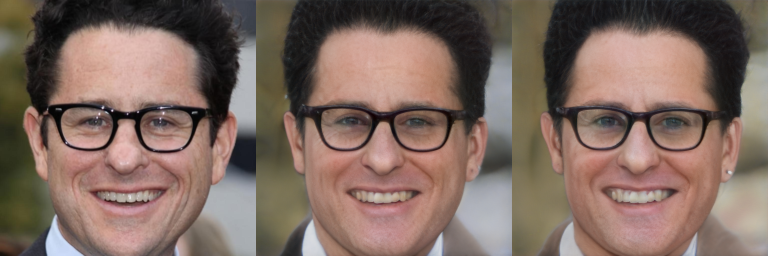

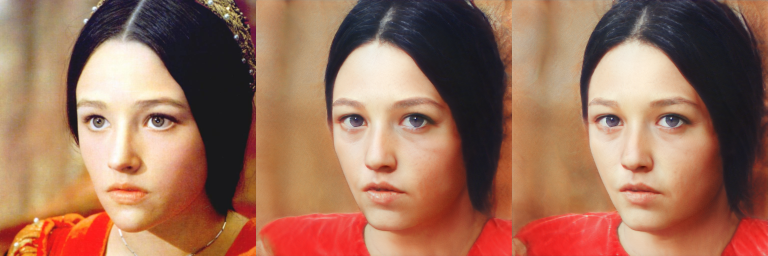

id-1


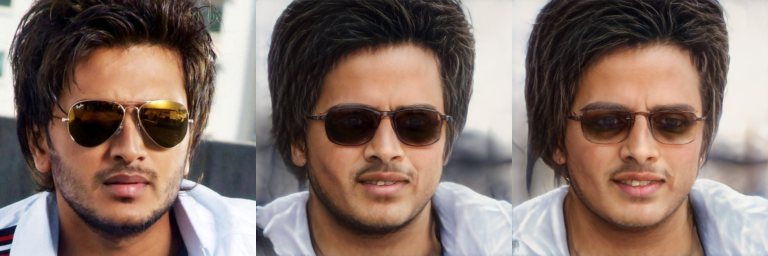

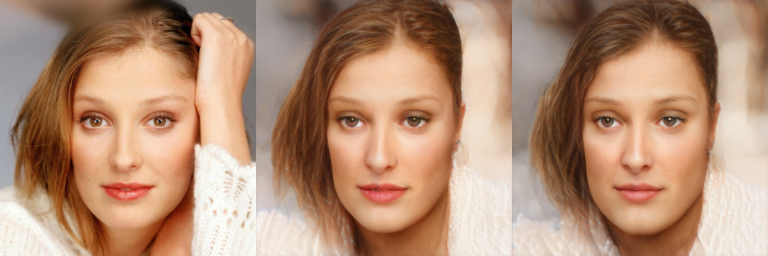

id-2


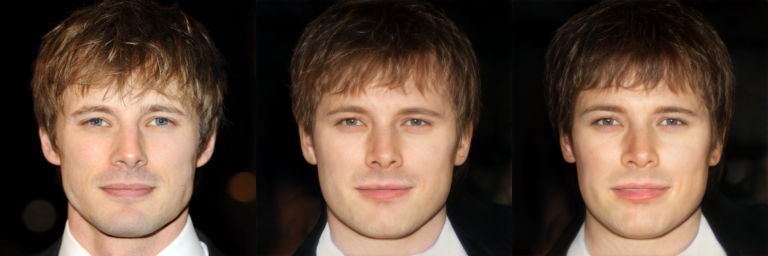

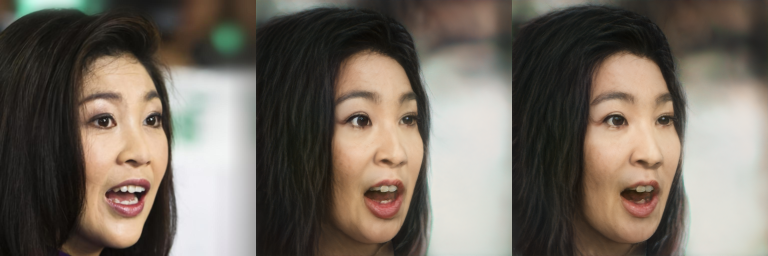

id-3


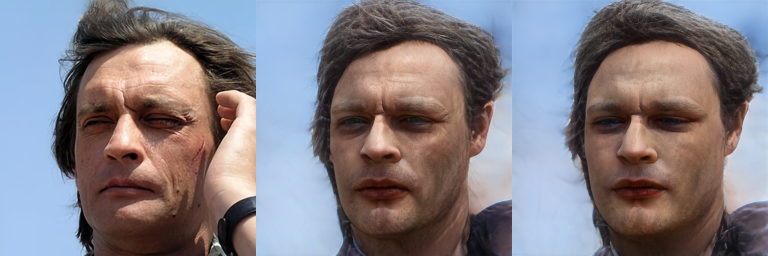

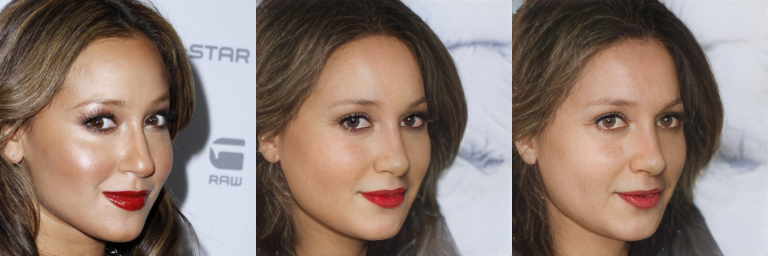

In [14]:
# batched_input shape: bs x 3 x w x h
# avaliable seed for ages:   815  6765 7352  9936  476 4432
# Generate a random integer  
# smile seed 53  
# for dog-cat seed: 7856  9603 5388
# for celebaHQ v1 gender seed: 7398 2379 
# for celebaHQ v1 smile seed: 1747 
import random
random_seed = random.randint(0, 10000)  # Using the range of a typical 32-bit signed integer
print('seed: ', random_seed)  
# random_seed = 7398
# image_bg_paths = 'notebooks/gender/male'
# image_t_paths = 'notebooks/gender/female'
%matplotlib inline
images_bg = load_folder_images(image_bg_paths, num_images=4, seed=random_seed)
images_t= load_folder_images(image_t_paths, num_images=4, seed=random_seed)

input_images_bg = transform_images_to_batch(images_bg, transform).to(device).float()
input_images_t = transform_images_to_batch(images_t, transform).to(device).float()

# custom_indices = torch.tensor([3, 0, 1, 2])  # Example custom order for batch size of 4
# input_images_bg = input_images_bg[custom_indices]

output_images_1, output_latents_1 = evaluate_model(csmlp_net, pSp_net, input_images_bg, input_images_t, opts)

# # visulize_images_batch(recon_t, axis_dim=1)
n_images = output_images_1['recon_pSp_bg'].shape[0]

# for i in range (n_images):
#     visulize_singleImg_paired2(input_images_bg[i,:,:,:], output_images_1['recon_bg'][i,:,:,:])
# for i in range (n_images):
#     visulize_singleImg_paired2(input_images_t[i,:,:,:], output_images_1['recon_t'][i,:,:,:])

for i in range (n_images):
    print(f'id-{i}')
    visulize_singleImg_paired3(input_images_bg[i,:,:,:], output_images_1['recon_bg'][i,:,:,:], output_images_1['recon_bg_swap'][i,:,:,:])
    visulize_singleImg_paired3(input_images_t[i,:,:,:], output_images_1['recon_t'][i,:,:,:],  output_images_1['recon_t_swap'][i,:,:,:])
    

In [7]:
# # compute output sparsity for latent_t_s
# #images_idx = 1
# show_latent_map(output_latents_1['latent_t_s'], img_idx = 0, show_weight = 50)
# show_latent_map(output_latents_2['latent_t_s'], img_idx = 0, show_weight = 50)
# show_latent_map(output_latents_3['latent_t_s'], img_idx = 0, show_weight = 50)

# calculate_output_sparsity

In [8]:
import torch

x = torch.tensor([3.0, 4.0, 5.0])  # Example vector
l2_norm = torch.norm(x, p=2)  # Compute L2 norm
print(l2_norm)  # Output: 7.0711


tensor(7.0711)


In [9]:
import torch

# Example tensor S_t of shape [batch_size, 18, 512]
S_t = torch.randn(4, 18, 512)  # Shape: [batch_size=4, 18 matrices per sample, 512 dimensions]

# Compute L2 norm for each 1x512 matrix
St_loss = ((torch.norm(S_t, p=2, dim=2) - 1.0) ** 2).mean()

print("St Loss:", St_loss)


St Loss: tensor(467.8004)


In [10]:
# Direct normalization using F.normalize
S_t = torch.randn(4, 18, 512)
S_t_normalized = torch.nn.functional.normalize(S_t, p=2, dim=2)  # Always normalized during forward pass
S_t_normalized.shape

torch.Size([4, 18, 512])

In [11]:
x_normalized = torch.nn.functional.normalize(x, p=2, dim=0)  # Normalize along dimension 0
print(x_normalized)  # Output: [0.4243, 0.5657, 0.7071]


tensor([0.4243, 0.5657, 0.7071])


In [12]:
import math
math.sqrt(512)

22.627416997969522